# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w
import explore_mod as em

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Project Description

The aim of this project is to look at what drives customer churn for a fictional company, Telco.

The main goals are:

- Identify key demographic of churning customers.
- Determine at least two factors that contribute to customer churn.
- Predict with at least 80% accuracy whether a given customer will churn.
- Provide stakeholders with recommendations as to how to reduce customer churn.

## Hypothesis:

> monthly_charges and tenure will be the most determining factors of whether a customer will churn.

# Data Wrangling

First, we'll get our data from the database. The function will save a local copy.

In [2]:
telco = w.get_telco_data()

telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


This is the second round of going over my data after completing MVP. What had struck out to me was that those who don't have internet have a really low churn rate.

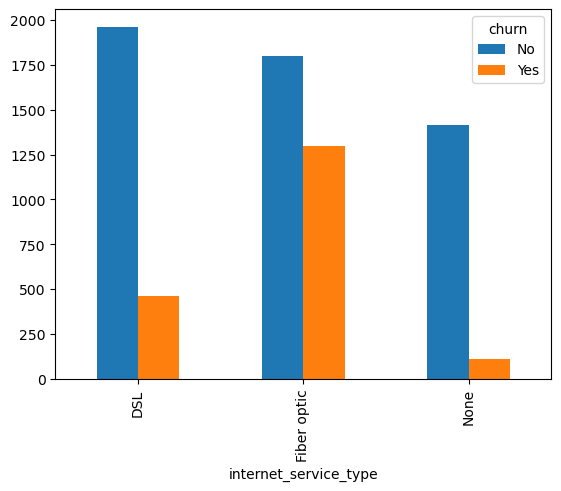

In [3]:
pct = pd.crosstab(telco.internet_service_type, telco.churn)
pct.plot.bar()
plt.show()

In [4]:
pd.crosstab(telco.internet_service_type, telco.churn, margins=True)

churn,No,Yes,All
internet_service_type,,,
DSL,1962,459,2421
Fiber optic,1799,1297,3096
None,1413,113,1526
All,5174,1869,7043


Of those that don't have internet, 113 out of 1526 churn (7.4% within group, 1.6% of total customers).

Of those that do have internet, 1756 out of 5517 churn (31.83% within group, 24.93% of total customers).

**I will isolate the dataset to only contain those who have internet, and predict their churn.**

Next, we'll run our data through a function that will handle null values and format the data for easy exploration and modeling.

In [5]:
telco = w.prep_telco(telco) 

# total_charges had 'sneaky' nulls (a space saved as a string), which were replaced with 0s and converted to dtype float.

telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,multiple_lines_No phone service,multiple_lines_Yes,online_security_Yes,tech_support_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,0,0,1,1,0,0,0,0,1
0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,1,0,0,0,0,0,0,0,1
0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,0,1,0,1,0
0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,0,0,0,0,0,1,0,1,0
0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,0,1,0,0,1,0,0,1


Finally, we'll split the data into a train, validate, and test set, and continue our exploration, hypothesis testing, and modeling on the training dataset alone.

In [6]:
train_telco, validate_telco, test_telco = w.split_data(telco, 'churn')

train_telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,multiple_lines_No phone service,multiple_lines_Yes,online_security_Yes,tech_support_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
3474-BAFSJ,Male,0,Yes,No,57,No,No phone service,No,Yes,Yes,...,1,0,0,1,0,1,0,0,0,0
6599-RCLCJ,Male,0,Yes,No,47,Yes,Yes,No,Yes,Yes,...,0,1,0,1,0,0,1,0,1,0
4631-OACRM,Male,1,No,No,15,Yes,No,No,No,No,...,0,0,0,0,0,0,1,0,1,0
2867-UIMSS,Male,0,No,No,1,Yes,No,No,No,No,...,0,0,0,0,0,0,1,0,1,0
9842-EFSYY,Female,0,No,Yes,4,No,No phone service,Yes,Yes,Yes,...,1,0,1,0,0,0,0,0,0,1


# Data Exploration

We will look at the following variables:

- tenure
- monthly_charges
- online_security
- tech_support
- contract_type
- payment_type

1) Does tenure affect whether a customer will churn? At what point in the customer's lifecycle should the client take action?

TENURE


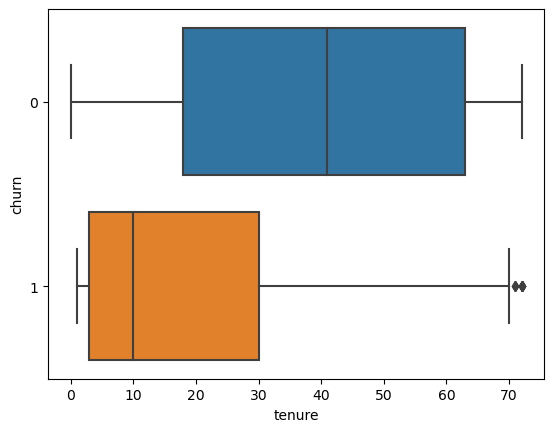


Stats results for tenure vs churn:

Stat value: 1782203.0
P-value: 4.214882008010433e-119



In [7]:
em.get_variable_viz(train_telco, 'tenure')

In [8]:
telco[telco.churn == 1].tenure.median() # Take a look at median tenure.

10.0

Yes, we can state that tenure affects whether a customer will churn. On average, 50% of customers that will churn will churn by the 10-month mark.

2) Do monthly_charges affect whether a customer will churn? How much more do churning customers spend a month?

MONTHLY_CHARGES


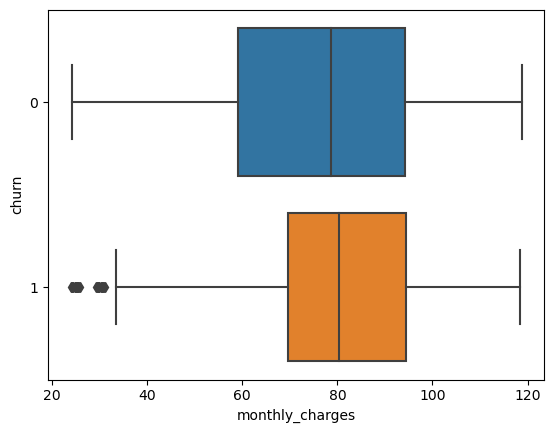


Stats results for monthly_charges vs churn:

Stat value: 1127920.5
P-value: 0.018203216295552393



In [9]:
em.get_variable_viz(train_telco, 'monthly_charges')

In [10]:
# To get average difference in how much people pay per month.

(telco[telco.churn == 1].monthly_charges.mean() - telco[telco.churn == 0].monthly_charges.mean())

1.579453686043962

Even though p-value is smaller than usual $\alpha$ = .05, I will drop this from my features sent into modeling. Note that on average, those who churn only pay $1.57 more per month. P-value must be small because of size of dataset.

3) Does online_security affect whether a customer will churn?

ONLINE_SECURITY


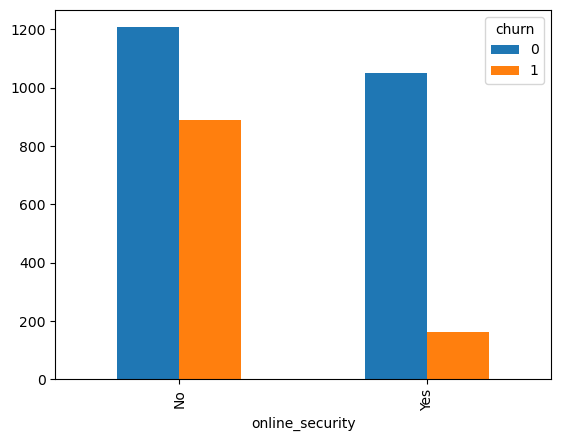


Stats results for online_security vs churn:

Chi^2 value: 295.15665094757287
P-value: 3.741125083006409e-66



In [11]:
em.get_variable_viz(train_telco, 'online_security')

Yes, we can state that online_security affects churn.

4) Does tech_support affect whether a customer will churn?

TECH_SUPPORT


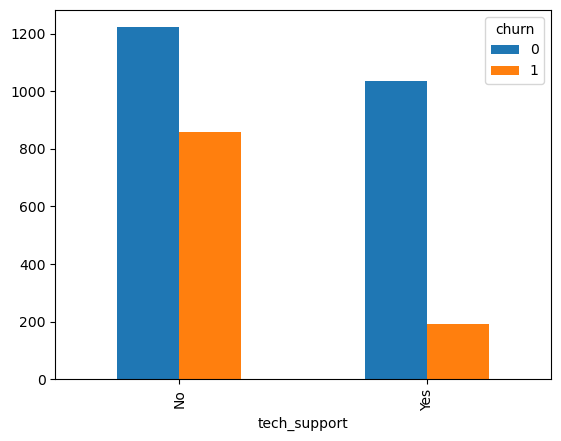


Stats results for tech_support vs churn:

Chi^2 value: 230.68328496178435
P-value: 4.229903605783304e-52



In [12]:
em.get_variable_viz(train_telco, 'tech_support')

Yes, we can state that tech_support affects churn.

5) Does contract_type affect whether a customer will churn?

CONTRACT_TYPE


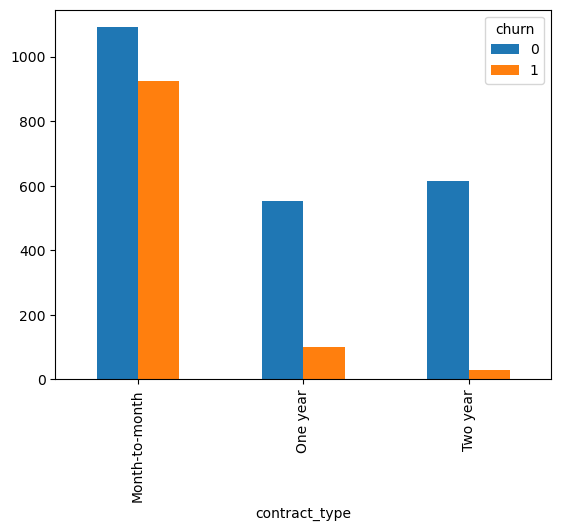


Stats results for contract_type vs churn:

Chi^2 value: 483.4465626663888
P-value: 1.04933164316652e-105



In [13]:
em.get_variable_viz(train_telco, 'contract_type')

Yes, we can state that contract type affects whether a customer will churn.

6) Does payment_type affect whether a customer will churn?

PAYMENT_TYPE


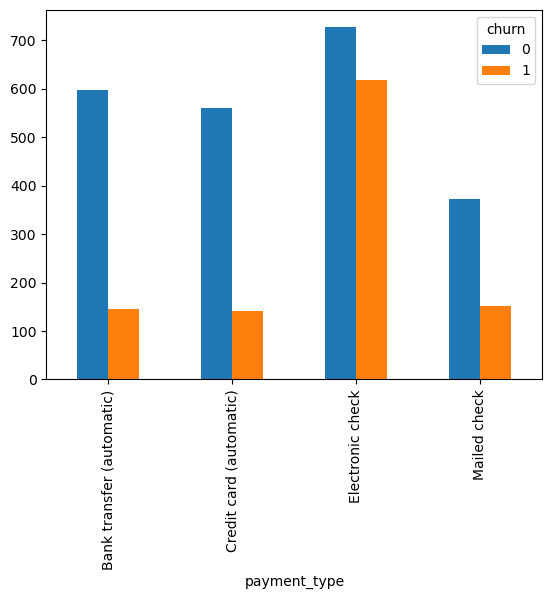


Stats results for payment_type vs churn:

Chi^2 value: 221.26406603908833
P-value: 1.0701969181413735e-47



In [14]:
em.get_variable_viz(train_telco, 'payment_type')

In [26]:
pd.crosstab(train_telco.payment_type, train_telco.churn, margins=True) # digging into e-check details

churn,0,1,All
payment_type,,,
Bank transfer (automatic),597,145,742
Credit card (automatic),560,141,701
Electronic check,726,617,1343
Mailed check,372,151,523
All,2255,1054,3309


Yes, we can state that payment type affects whether a customer will churn. 45.94% of customers that pay with electronic check have churned.

# Key Findings

- The variables had the following p-values, in descending order.
  - tenure e-119
  - contract type e-105
  - online security e-66
  - tech support e-52
  - payment type e-47
  - monthly charges .01
- On average, 50% of customers that will churn will churn by the 10-month mark.
- Fiber optic internet service has a much higher ratio of churn:no_churn than DSL.
- Month-to-month contract type is most susceptible to churn.
- 7.40% of customers with no internet will churn vs. 31.83% of customers with internet.
- Among those who have internet, customers who churn pay an average of $1.57 more than those who don't per month.
- 45.94% of customers that pay with electronic check have churned.

# Data Modeling

We'll run the features we identified to affect churn into different classification models.

### Setting a baseline

In [15]:
train_telco.churn.value_counts()

0    2255
1    1054
Name: churn, dtype: int64

Baseline accuracy to beat in our models is 2255/(2255+1054) = 68.14%

### Splitting our dataset into the features we need to send into our model.

We'll use the encoded variables for the features we want to send in.

In [19]:
features = ['tenure', 'contract_type_One year', 'contract_type_Two year', 'online_security_Yes', 'tech_support_Yes', 'payment_type_Credit card (automatic)', 'payment_type_Electronic check', 'payment_type_Mailed check']

Preparing our data for input into different classification models.

In [20]:
X_train = train_telco[features]
y_train = train_telco.churn

X_validate = validate_telco[features]
y_validate = validate_telco.churn

X_test = test_telco[features]
y_test = test_telco.churn

## Performance Check across all Classification Models

For-loops were previously run for each classification model to find optimal accuracy while controlling for overfit of data. Below shows the best performance metrics for each model.

In [21]:
em.classification_models_performance(X_train, y_train, X_validate, y_validate)

,model,train,validate,hyper_value,difference
0,Decision Tree,0.755515,0.755435,6,0.000080
1,Random Forest,0.755213,0.756341,6,-0.001128
2,KNN,0.764884,0.721014,8,0.043869
3,Logistic Regression,0.747658,0.752717,10,-0.005059


We'll go with Random Forest (depth=6) since it's least susceptible to overfit of data.

# Predictions

Using our chosen model, we'll cast predictions as to whether a customer will churn on our X_test, y_test dataset.

The results are saved in the predictions.csv file on the local directory.

In [22]:
rfc = RandomForestClassifier(max_depth=6, min_samples_leaf=5)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)

predictions = pd.DataFrame({'customer_id': X_test.reset_index().customer_id, #reset_index since customer_id was set to index in prep
             'prediction': y_pred,
             'churn_prob': y_prob[:,1]})

predictions.to_csv('predictions.csv', index=False) # Saving to csv.

predictions.head() # Preview of csv file contents.

,customer_id,prediction,churn_prob
0,3002-WQZWT,0,0.467101
1,8080-POTJR,0,0.111941
2,7054-LGEQW,1,0.587329
3,4546-FOKWR,0,0.430703
4,5193-QLVZB,0,0.127593


# Takeaways

- We did not meet our goal of predicting churn with 80% accuracy.


Next steps:

- We should look further into tech support as a likely factor.

# Recommendations

- Invest in R&D for their Fiber Optic service.
- Offer incentives to customers once they hit the 10-month mark.
- Look into possible issues with electronic check payments. Might be client-side, might be customer-side.
- Offer incentives for customers to switch to automatic method of payment.